In [ ]:
'''
Queries JPL Horizons for Jupiter, Saturn, Uranus, and Neptune and plots airmasses over time. Will also plot and any manually-entered cal stars, but have to save those airmasses manually.
Uses https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html to query Horizons. See github page for info on requirements and installation.

To do: could make x-axis more intuitive with better time labels.

Emma Dahl, 2/22/2023
'''

In [1]:
from astroquery.jplhorizons import Horizons
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

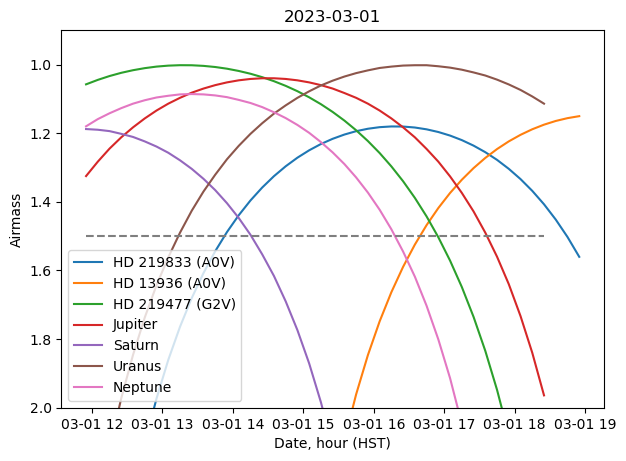

In [13]:
fig, ax = plt.subplots(dpi=100)
fig.set_size_inches(7, 5) # set size

# UTC = HST + 10 hrs
observing_start_time_UTC = '2023-03-01 21:55:00'
observing_end_time_UTC = '2023-03-02 04:25:00' # day after
save_location = './march_2023/airmass_plot.png' # name and where the figure will be saved
planets = ('599','Jupiter'),('699','Saturn'),('799','Uranus'),('899','Neptune') # tuples to be looped through

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - Cal stars

# Horizons doesn't take an RA and dec and provide airmasses :( - so find stars on http://irtfweb.ifa.hawaii.edu/~spex/find_a0v/ and then go to http://www.mirametrics.com/airmass_planner.php to pull its airmasses over observing_start_time_UTC and observing_end_time_UTC, save that text file locally and then load it here. Clunky but it will work! IRTF lat/long is 19 49 34.38594, 155 28 19.19564. Time step to match whatever other time step is used in call to Horizons (probably 10 mins), use UTC and this program will convert to HST when plotting.

star1_label = 'HD 219833 (A0V)'
star1_file = '/Users/emmadahl/Desktop/Observing/march_2023/HD219833'

star2_label = 'HD 13936 (A0V)'
star2_file = '/Users/emmadahl/Desktop/Observing/march_2023/HD13936'

star3_label = 'HD 219477 (G2V)'
star3_file = '/Users/emmadahl/Desktop/Observing/march_2023/HD219477'

stars = (star1_file,star1_label),(star2_file,star2_label),(star3_file,star3_label)

for j in stars:
    with open(j[0],'r') as f:
        all_data=[x.split() for x in f.readlines()]
        star=np.array(all_data[1:])
    airmasses = np.asfarray(star[:,3])
    # Make array of datetime objects for combined dates and times from file. Ignore decimals in seconds
    star_dates = []
    for i in range(0,len(star)):
        star_dates.append(datetime.strptime(star[i,1]+' '+star[i,2][:-2], '%Y-%m-%d %H:%M:%S'))
    plt.plot(np.array(star_dates)-timedelta(hours=10), airmasses, label=j[1])

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - Outer Planets

for k in planets:
    # Define Jupiter object; 568 = Mauna Kea
    id_number = k[0] # horizons planet code
    planet_label = k[1]
    obj = Horizons(id=id_number, location='568', epochs={'start':observing_start_time_UTC,\
                                                          'stop':observing_end_time_UTC, \
                                                          'step':'10m'}) 
    # put ephimerides into a table
    table = obj.ephemerides() 
    # convert day/time to usable units:
    dates = []
    for i in table['datetime_str']:
        dates.append(datetime.strptime(i, '%Y-%b-%d %H:%M')) # define the format of the datetime_str column
    # Plot curve, converting time to HST:
    plt.plot(np.array(dates)-timedelta(hours=10), table['airmass'],label=planet_label)


# line at 1.5 airmasses; limit for this observing run
plt.plot([datetime.strptime(observing_start_time_UTC, '%Y-%m-%d %H:%M:%S')-timedelta(hours=10), datetime.strptime(observing_end_time_UTC, '%Y-%m-%d %H:%M:%S')-timedelta(hours=10)], [1.5,1.5], '--')

plt.gca().invert_yaxis()
plt.title(str(datetime.strptime(observing_start_time_UTC, '%Y-%m-%d %H:%M:%S').date()))
plt.ylabel('Airmass')
plt.xlabel('Date, hour (HST)')
plt.legend()
plt.ylim(2.0,0.9)
plt.savefig(save_location, bbox_inches='tight')
plt.show()